In [4]:
import ccxt
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pytz
from collections import OrderedDict


plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')


In [8]:
binance = ccxt.binance()
coin = 'BTC/USDT'
timeframe = '1d'
limit = 365
data = binance.fetch_ohlcv(coin, timeframe, limit = limit)
df = pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])
df['date'] = pd.to_datetime(df['date'], unit='ms')
df.set_index('date', inplace=True)

In [9]:
df.head()

,open,high,low,close,volume
date,,,,,
2022-04-03,45810.99,47444.11,45530.92,46407.35,33394.67794
2022-04-04,46407.36,46890.71,45118.00,46580.51,44641.87514
2022-04-05,46580.50,47200.00,45353.81,45497.55,42192.74852
2022-04-06,45497.54,45507.14,43121.00,43170.47,60849.32936
2022-04-07,43170.47,43900.99,42727.35,43444.19,37396.54156


In [10]:
df.tail()

,open,high,low,close,volume
date,,,,,
2023-03-29,27261.06,28650.00,27240.10,28348.60,89486.16008
2023-03-30,28348.60,29184.68,27686.00,28028.53,98865.43256
2023-03-31,28028.53,28656.69,27511.71,28465.36,78198.12139
2023-04-01,28465.36,28819.71,28220.27,28452.73,30238.44753
2023-04-02,28452.74,28530.00,28355.00,28416.38,6443.21833


In [11]:
df.to_csv('btc_ohlv.csv')

In [12]:
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

df_macd = get_macd(df['close'], 26, 12, 9)
df_macd.tail()

df = pd.concat([df, df_macd], join = 'inner', axis =1)

In [13]:
df.to_csv(f'btc_ohlv_macd.csv')

In [14]:
def plot_macd(prices, macd, signal, hist):
    plt.figure(figsize = (12,8))
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan=5, colspan=1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan=3, colspan=1, sharex=ax1)
    
    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', lw = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'blue', lw = 1.5, label = 'Signal')
    
    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')
    plt.legend(loc = 'lower right')
    plt.tight_layout()
    plt.show()    

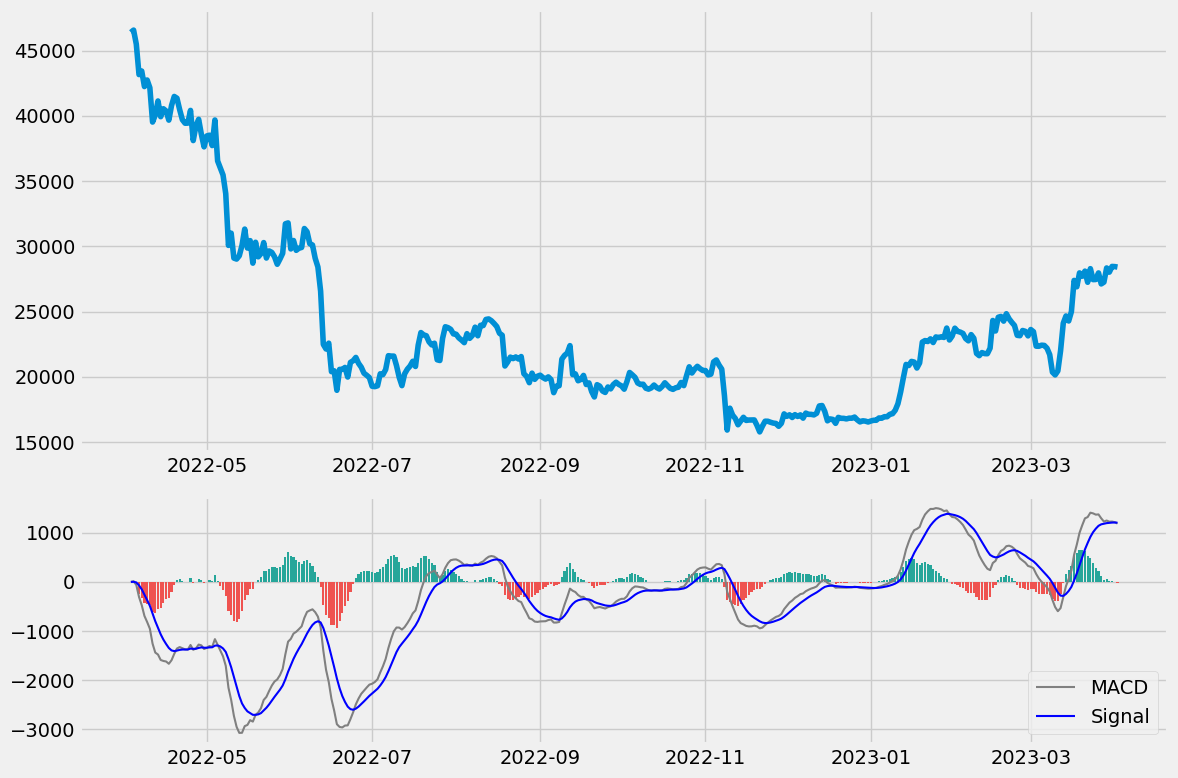

In [15]:
plot_macd(df['close'], df['macd'], df['signal'], df['hist'])

In [16]:
def implement_macd_strategy(prices, data):
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
    
    return buy_price, sell_price, macd_signal

        
            

In [17]:
buy_price, sell_price, maxd_signal = implement_macd_strategy(df['close'], df_macd)

In [18]:
buy = pd.DataFrame(buy_price, columns = ['buy_price'])
sell = pd.DataFrame(sell_price, columns = ['sell_price'])
buy.dropna(inplace= True)
sell.dropna(inplace= True)

In [19]:
sum_buy = buy.sum()
sum_sell = sell.sum()
print(sum_buy[0])
print(sum_sell[0])
profit = sum_sell[0] - sum_buy[0]
print(f'Profit: {profit}')

419046.72000000003
413728.51
Profit: -5318.210000000021
